In [499]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from synthid_text.detector_frequentist import frequentist_score, weighted_frequentist_score
from scipy.stats import norm
import matplotlib.ticker as ticker
from statsmodels.stats.proportion import proportions_ztest

In [500]:
MODEL_NAMES = [ # can comment out models to exclude them
    # "google/gemma-2b-it", 
    "google/gemma-7b-it", 
    # "mistralai/Mistral-7B-Instruct-v0.3", 
    "meta-llama/Llama-3.1-8B-Instruct", 
    # "ISTA-DASLab/Meta-Llama-3.1-70B-Instruct-AQLM-PV-2Bit-1x16"
    ]
COLORS = ["#FF5733", "#33FF57", "#3357FF", "#FF33AA", "#8E44AD"]
TEMPERATURE = 0.5
ROC_TOKEN_LIMIT = 200 # only consider up to e.g. 200 tokens
USE_WEIGHTED = True
IS_WATERMARKED = True
ROC_SEGMENTS = 10

In [501]:
F_MODEL_NAMES =  [name.replace("/", "_") for name in MODEL_NAMES]
frequentist_score = frequentist_score if not USE_WEIGHTED else weighted_frequentist_score
WM_STR = "wm" if IS_WATERMARKED else "uwm"
WM_SUFFIX = " (unwatermarked)" if not IS_WATERMARKED else ""
WEIGHTED_SUFFIX = "" if USE_WEIGHTED else " (unweighted)"

In [502]:
padded_eli5_g_values = [torch.load(f"../frequentist_experiment_data/eli5_g_values_{F_MODEL_NAME}_t={TEMPERATURE}_{WM_STR}.pt", map_location=torch.device('cpu')) for F_MODEL_NAME in F_MODEL_NAMES]
padded_eli5_combined_mask = [torch.load(f"../frequentist_experiment_data/eli5_combined_mask_{F_MODEL_NAME}_t={TEMPERATURE}_{WM_STR}.pt", map_location=torch.device('cpu')) for F_MODEL_NAME in F_MODEL_NAMES]

/var/folders/59/7skhmmps2b17ysy_h9b099zh0000gn/T/ipykernel_84365/2118954140.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  padded_eli5_g_values = [torch.load(f"../frequ

In [503]:
# Mean Response Lengths
avg_seq_lens = [torch.mean(torch.sum(padded_eli5_combined_mask[i], dim=1).double()).item() for i in range(len(MODEL_NAMES))]

In [ ]:
# Maximum true positive rate that we can be lower than with significance level p=0.05

sample_sizes = [len(gvals) for gvals in padded_eli5_g_values]
MIN_UPPERS = {}
MIN_UPPER_COLORS = {
    100: "black",
    50: "gray"
}
for n in sample_sizes:
    tpr = 1 / n
    se = np.sqrt((tpr * (1 - tpr)) / n)
    MIN_UPPER = tpr + norm.ppf(0.975) * se
    MIN_UPPERS[n] = MIN_UPPER
MIN_UPPERS

{100: 0.029501395417987873, 10000: 0.000295986598389075}

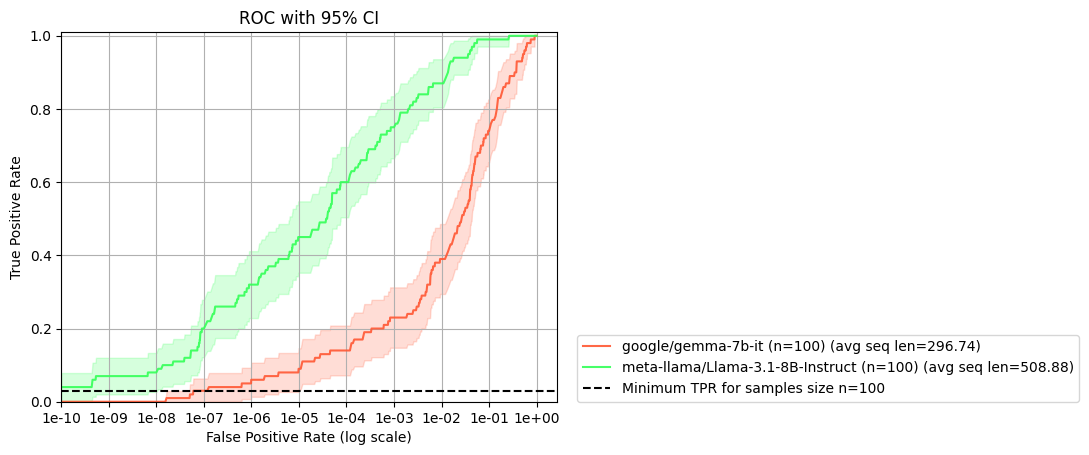

In [505]:
# ROC Curve

def ROC(freq_scores, title_suffix="", log_scale=False, truncated=False):
    for i in range(len(MODEL_NAMES)):
        # Given parameters
        segment_bounds = [1 / 10**(ROC_SEGMENTS -i) for i in range(ROC_SEGMENTS)] + [1]
        segments = [np.linspace(segment_bounds[i], segment_bounds[i + 1], 100) for i in range(ROC_SEGMENTS)]
        fprs = np.stack(segments).flatten()

        # Compute TPR as proportion of samples that meet criterion at each FPR threshold
        tprs = np.array([
            np.sum(-freq_scores[i] <= fpr) / len(freq_scores[i])
            for fpr in fprs
        ])

        # Sample size
        n = len(freq_scores[i])
        z = norm.ppf(0.975)  # ~1.96 for 95% CI

        # Compute standard error for each TPR
        se = np.sqrt((tprs * (1 - tprs)) / n)

        # Compute 95% confidence intervals
        tprs_lower = tprs - z * se
        tprs_upper = tprs + z * se

        # Bound the intervals between 0 and 1
        tprs_lower = np.clip(tprs_lower, 0, 1)
        tprs_upper = np.clip(tprs_upper, 0, 1)

        # Plot
        if log_scale:
            fprs = np.log(fprs)
        plt.plot(fprs, tprs, label=MODEL_NAMES[i] + f" (n={n})" + (f" (avg seq len={avg_seq_lens[i]})" if not truncated else ""), color=COLORS[i], alpha=0.9)
        plt.fill_between(fprs, tprs_lower, tprs_upper, color=COLORS[i], alpha=0.2)
    plt.title(f"ROC with 95% CI{title_suffix}" + WM_SUFFIX + WEIGHTED_SUFFIX)
    plt.xlabel("False Positive Rate" + (" (log scale)" if log_scale else ""))
    plt.ylabel("True Positive Rate")
    for n in MIN_UPPERS:
        plt.axhline(MIN_UPPERS[n], color=MIN_UPPER_COLORS[n], linestyle="--", label="Minimum TPR for samples size n=" + str(n))
    plt.ylim(0, 1.01)
    plt.xlim(0, 1.0)

    if log_scale:
        plt.xticks(np.log(segment_bounds), [f"{b:.0e}" for b in segment_bounds])


    plt.legend(loc=(1.04, 0))
    plt.grid()

    plt.show()
    
eli5_freq_scores = [frequentist_score(
    padded_eli5_g_values[i].cpu().numpy(),
    padded_eli5_combined_mask[i].cpu().numpy()
) for i in range(len(MODEL_NAMES))]
ROC(eli5_freq_scores, log_scale=True)

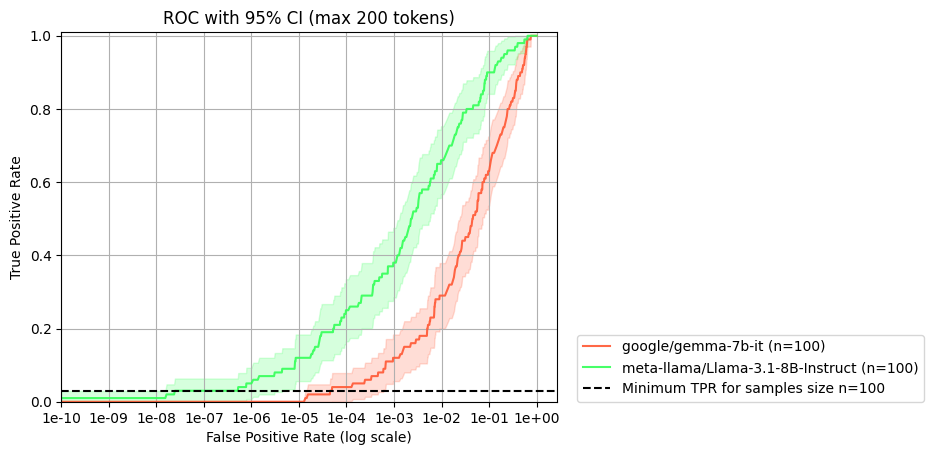

In [506]:
# ROC Curve for first ROC_TOKEN_LIMIT tokens
# To avoid having models that output more text getting better detectability

eli5_freq_scores_limited = [frequentist_score(
    padded_eli5_g_values[i].cpu().numpy()[:,:ROC_TOKEN_LIMIT,:], padded_eli5_combined_mask[i].cpu().numpy()[:,:ROC_TOKEN_LIMIT]
) for i in range(len(MODEL_NAMES))]

ROC(eli5_freq_scores_limited, f" (max {ROC_TOKEN_LIMIT} tokens)", log_scale=True, truncated=True)
